In [1]:
import pandas as pd
import warnings
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.core.display import display, HTML 
# display(HTML("<style>.container { width:80% !important; }</style>"))
warnings.filterwarnings('ignore')
train=pd.read_csv("train_data.csv")
test=pd.read_csv("test_data.csv")
import pandas_profiling as pdp
df=pd.concat([train,test],sort=False)


/home/ogata/.pyenv/versions/3.7.0/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/ogata/.pyenv/versions/3.7.0/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
!pip install heamy

  Created wheel for heamy: filename=heamy-0.0.7-py2.py3-none-any.whl size=15352 sha256=7b0903ab133b2f75b6dbce5eb50566fb91353c0e6f94f352f031d303f2239294
  Stored in directory: /home/ogata/.cache/pip/wheels/ab/05/27/334fcc59e6279e70d84880e6988ea934d740829a900f14352f
Successfully built heamy


In [92]:
import pandas_profiling as pdp
from sklearn.decomposition import PCA
def preprocess():
    
    train=pd.read_csv("train_data.csv")
    test=pd.read_csv("test_data.csv")
#     print(train)
    df=pd.concat([train,test],sort=False)
    df.age=df.age.map(lambda x:57 if x>58 else x)
    df.num_child=df.num_child.map(lambda x:7 if x>7 else x)
    df.study=df.study_time.map(lambda x:17 if x>17 else x)
    df["familiy_num"]=1+df.partner+df.num_child
    arealist=list(train.groupby("area").mean().salary.sort_values().index)
    areadic={}
    df.loc[((df["area"]=="東京都") | (df["area"]=="大阪府")) & (df["partner"]==1), "commute"] = \
      df[((df["area"]=="東京都") | (df["area"]=="大阪府")) & (df["partner"]==1)]["commute"].apply(lambda x : max(x/2 , 0))
    df.loc[((df["area"]!="東京都") | (df["area"]!="大阪府")) & (df["partner"]==1), "commute"] = \
      df[((df["area"]!="東京都") | (df["area"]!="大阪府")) & (df["partner"]==1)]["commute"].apply(lambda x : max(x, 0))
    df.loc[((df["area"]=="東京都") | (df["area"]=="大阪府")) & (df["partner"]==0), "commute"] = \
      df[((df["area"]=="東京都") | (df["area"]=="大阪府")) & (df["partner"]==0)]["commute"].apply(lambda x : max(x*3/4, 0))
    df.loc[((df["area"]!="東京都") | (df["area"]!="大阪府")) & (df["partner"]==0), "commute"] = \
      df[((df["area"]!="東京都") | (df["area"]!="大阪府")) & (df["partner"]==0)]["commute"].apply(lambda x : max(x*8/9+1/2, 0))
    for i,area in enumerate(arealist):
        areadic[area]=i+1
    df.area=df.area.map(areadic)
    df.position=df.position+1
    df.sex=df.sex-1
    df.salary=np.log(df.salary)
    df["agexposition"]=df.age*df.position.map(lambda x:1 if x==1 else x)
    df["age_layer"] = 0
    df.loc[20>=df["age"], "age_layer"] = 0
    df.loc[(30>=df["age"])&(df["age"]>20), "age_layer"] = 1
    df.loc[df["age"]>30, "age_layer"] = 2
    df["agelayer_and_position"] = df["age_layer"].astype(str) + "_" + df["position"].astype(str)
    aplist=list(df.groupby("agelayer_and_position").mean().salary.sort_values().index)
    apdic={}
    for i,area in enumerate(aplist):
        apdic[area]=i+1
    df.agelayer_and_position=df.agelayer_and_position.map(apdic)
#     df["overxstudy"]=df.overtime +4*df.study_time
#     df["area_partner"] = df.area.map(lambda x:1if (x==47)|(x==46) else 0).astype(str) + "_" + df["partner"].astype(str)
#     applist=list(df.groupby("area_partner").mean().salary.sort_values().index)
#     print(applist)
#     appdic={}
#     for i,area in enumerate(applist):
#         appdic[area]=i+1
#     df.area_partner=df.area_partner.map(appdic)
#     splist=list(df.groupby("education_and_position").mean().salary.sort_values().index)
#     spdic={}
#     for i,area in enumerate(splist):
#         spdic[area]=i+1
#     df.education_and_position=df.education_and_position.map(spdic)
    
#     df["overtime_by_age"] = df["overtime"] / df["age"]
    
#     df.education=df.education+1
    
#     train["eduxposi"]=train.education*train.position
#     eduposi=list(train.groupby("eduxposi").mean().salary.sort_values().index)
#     eduposidic={}
#     for i,x in enumerate(eduposi):
#         eduposidic[x]=i+1
#     df["eduxposi"]=(df.education*df.position).map(eduposidic)

#     pca = PCA(n_components=1)
#     #モデルのパラメータをfitして取得しPCAオブジェクトへ格納
#     pca.fit(df.drop(["id","salary"],axis=1))

# #     print('Variance ratio: ' + str(pca.explained_variance_ratio_))
# #     print('Singular values: ' + str(pca.singular_values_))

#     #fitで取得したパラメータを参考にXを変換する
#     pca_X = pca.transform(df.drop(["id","salary"],axis=1))
#     df["pca"]=pca_X
#     df.drop(["sex"],axis=1)
#     print(df)
    train=df.dropna().drop(["id","age_layer"],axis=1)
    test=df[df.salary.isnull()].drop(["id","age_layer"],axis=1)
    test=test.drop(["salary",],axis=1)
    X = train.drop(["salary"],axis=1)
    y = train.salary
    return X,y,test,df
X,y,test,df=preprocess()
#original 23.625521293118492
train=pd.concat([X,y],axis=1)

In [93]:
# sns.scatterplot(x="commute",y="salary",data=pd.concat([X,y],axis=1),hue="area_partner")

In [94]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
def fair(preds,dtrain):
    x=pred-dtrain.get_labels()
    c=1
    den=abs(x)+c
    grad=c*x/den
    hess=c*c/den**2
    return grad,hess
model=lgb.LGBMRegressor(**{'objective':'huber','booster': 'gblinear',
                           'iterations': 309, 'depth': 16, 'learning_rate': 0.1,
                           'random_strength': 48, 'bagging_temperature': 19.715729096205934, 
                           'od_type': 'Iter', 'od_wait': 26, 'lambda_l1': 0.726486176355415, 
                           'lambda_l2': 0.00044177449020498015, 'num_leaves': 188,
                           'feature_fraction': 0.9443254919883529, 'bagging_fraction': 0.9271673814820428, 
                           'bagging_freq': 2, 'min_child_samples': 17})
scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
print(scores)
print(np.array(scores).mean())

[22.37040898267432, 21.959341080026885, 22.66108194382148, 22.41953793942754, 21.454570957302987]
22.17298818065064


In [12]:
df

id  position  age  area  sex  partner  num_child  education  \
0        0         2   44    45    1        1          2          1   
1        1         3   31    28    0        0          0          0   
2        2         3   36    26    0        0          0          2   
3        3         1   22    47    1        0          0          0   
4        4         1   25    14    1        0          0          1   
...    ...       ...  ...   ...  ...      ...        ...        ...   
8995  8995         2   43    14    1        0          0          0   
8996  8996         3   40     5    1        0          0          0   
8997  8997         5   46    24    0        0          0          0   
8998  8998         1   22    13    0        0          0          0   
8999  8999         3   49    14    0        1          0          2   

      service_length  study_time  commute  overtime    salary  familiy_num  \
0                 24         2.0      1.6       9.2  6.059298            4   
1                 13         9.0      0.7      12.4  5.761833            1   
2                 14         4.0      0.4      16.9  5.878717            1   
3                  4         3.0      0.4       6.1  5.304851            1   
4                  5         3.0      0.2       4.9  5.182163            1   
...              ...         ...      ...       ...       ...          ...   
8995              25         3.0      0.7       0.0       NaN            1   
8996              22         8.0      0.7       5.7       NaN            1   
8997              28         2.0      0.8       0.0       NaN            1   
8998               4         0.0      0.1       0.7       NaN            1   
8999              27         0.0      1.7      11.0       NaN            2   

      agexposition  age_layer  agelayer_and_position  area_partner  
0               88          2                      7             2  
1               93          2                     10             1  
2              108          2                     10             1  
3               22          1                      3             3  
4               25          1                      3             1  
...            ...        ...                    ...           ...  
8995            86          2                      7             1  
8996           120          2                     10             1  
8997           230          2                     12             1  
8998            22          1                      3             1  
8999           147          2                     10             2  

[30000 rows x 18 columns]

# Learning

In [74]:
from sklearn.model_selection import train_test_split, GridSearchCV

train_X, valid_X,train_y, valid_y = train_test_split(X,y,test_size=0.2,random_state=43)

In [75]:
pdp.ProfileReport(X)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


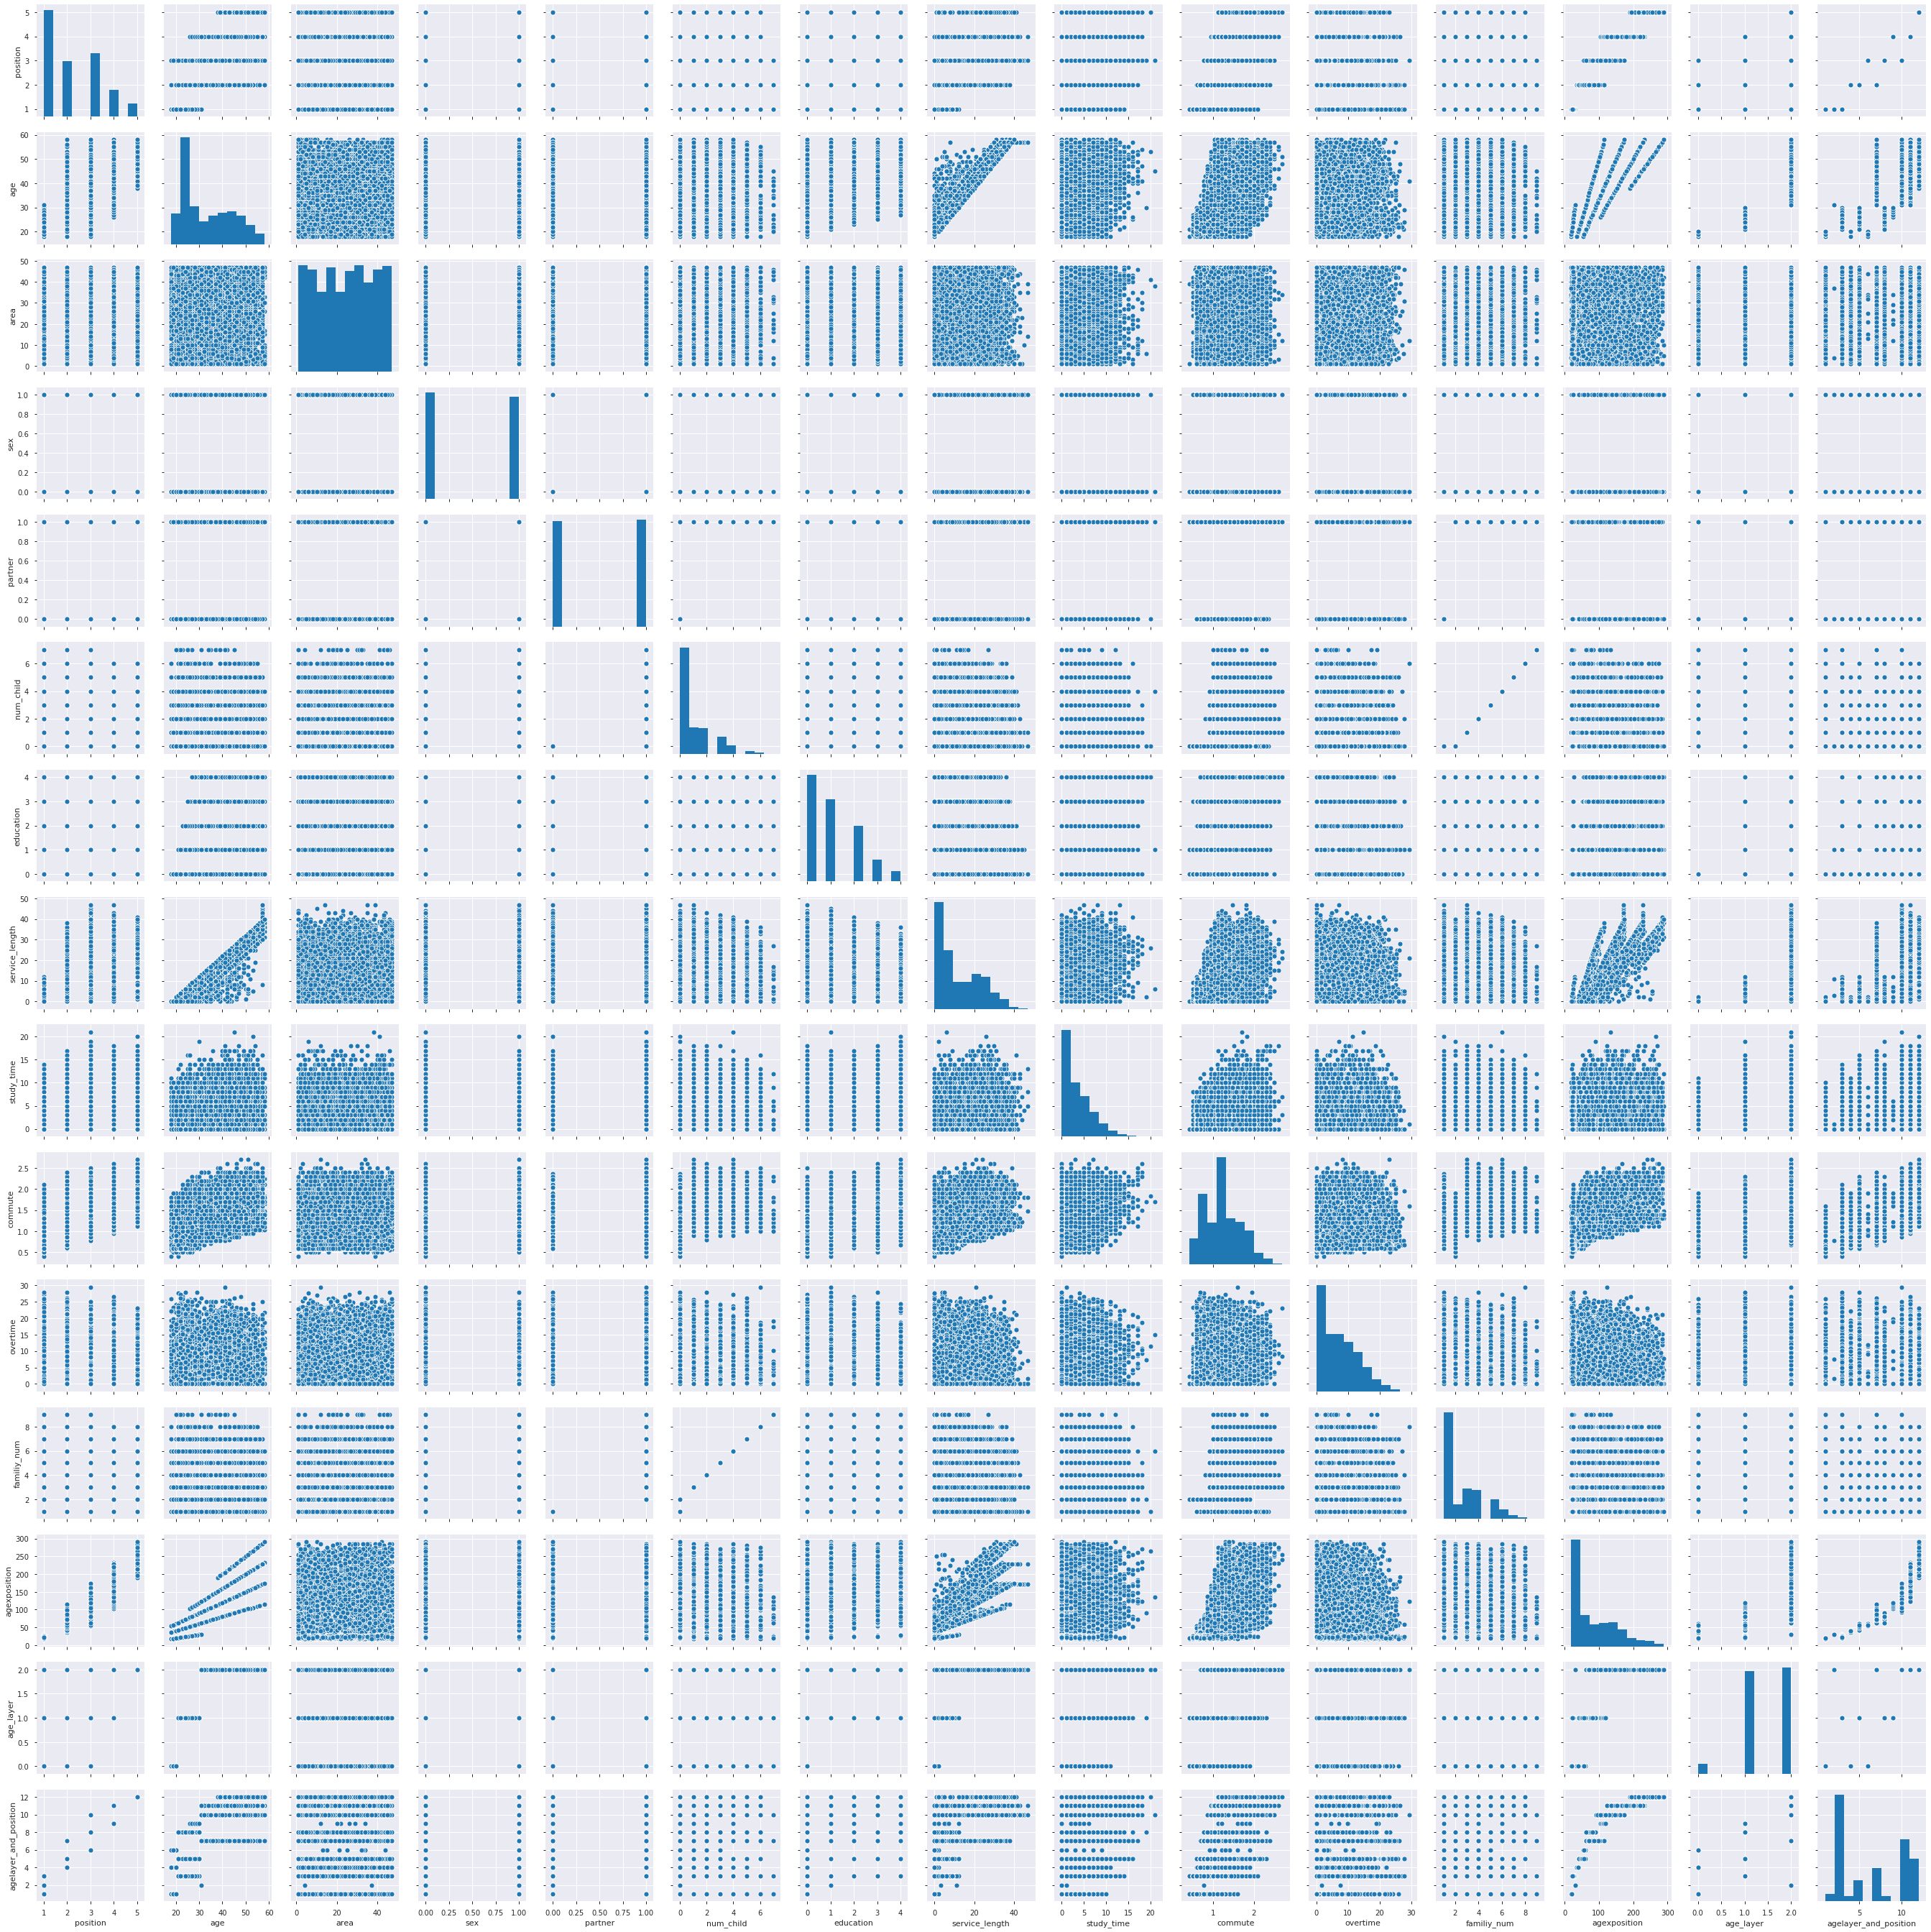

In [77]:
sns.pairplot(test)

KeyboardInterrupt: 

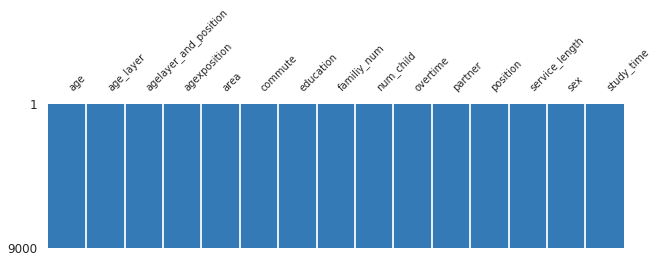

In [78]:
pdp.ProfileReport(test)

In [79]:
from sklearn.ensemble import RandomForestRegressor as RFR
import numpy as np
from sklearn.metrics import mean_absolute_error

rg = RFR(n_jobs=-1, random_state=2525)
 
rg.fit(train_X,train_y)
print(rg.score(valid_X,valid_y))
from sklearn.metrics import mean_squared_error
score=mean_absolute_error(np.exp(valid_y),np.exp(rg.predict(valid_X)))
print(f'MAE:{score:4f}')
fti = rg.feature_importances_

print('Feature Importances:')
for i,feat in enumerate(valid_X.columns):
    print('\t{0:10s} : {1:>.6f}'.format(feat, fti[i]))
col_names = test.columns.values
col_names_ = col_names[np.argsort(rg.feature_importances_)[::-1]]
col_names_

0.9578807105589799
MAE:22.836264
Feature Importances:
	position   : 0.002730
	age        : 0.003936
	area       : 0.011088
	sex        : 0.001028
	partner    : 0.001744
	num_child  : 0.022171
	education  : 0.030293
	service_length : 0.004022
	study_time : 0.004199
	commute    : 0.248103
	overtime   : 0.024911
	familiy_num : 0.022080
	agexposition : 0.621487
	age_layer  : 0.000188
	agelayer_and_position : 0.002021


array(['agexposition', 'commute', 'education', 'overtime', 'num_child',
       'familiy_num', 'area', 'study_time', 'service_length', 'age',
       'position', 'agelayer_and_position', 'partner', 'sex', 'age_layer'],
      dtype=object)

In [80]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
model=lgb.LGBMRegressor()
scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
print(scores)
print(np.array(scores).mean())

[22.692844414840565, 22.37173721936598, 23.198402004574948, 23.04273538955628, 22.1485511581641]
22.690854037300376


# ModelSelection

 82%|████████▏ | 9/11 [00:36<00:04,  2.34s/it]

[08:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:29:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:29:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:29:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:29:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

100%|██████████| 11/11 [00:46<00:00,  4.25s/it]


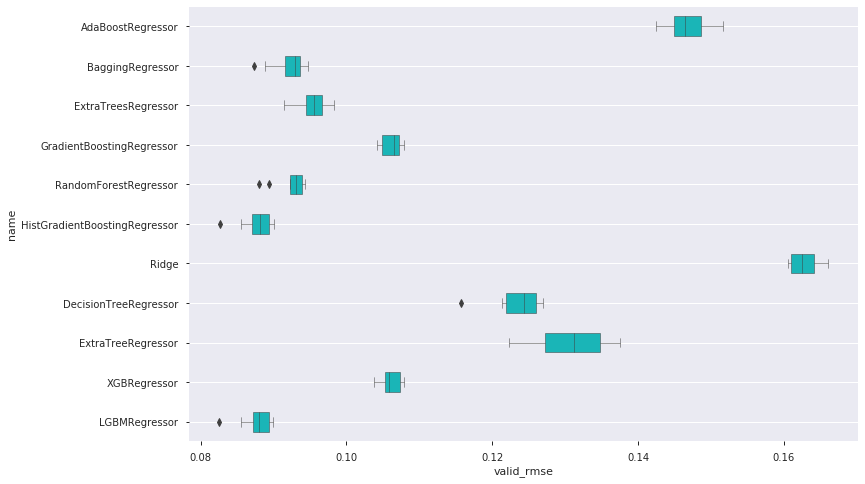

In [81]:
# 特徴量を選択して、複数のモデルで精度を調査する
from scipy.stats import mstats
from tqdm import tqdm
import matplotlib
from sklearn import metrics,  feature_selection, ensemble, gaussian_process, linear_model, naive_bayes, neighbors, svm, tree, discriminant_analysis, model_selection
# from imblearn import under_sampling, over_sampling
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import make_scorer
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
base_color = 'darkturquoise'
base_color2 = 'gray'

def generate_cmap(colors):
    
    values = range(len(colors))
    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append((v/vmax, c))
    return matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', color_list)
cm = generate_cmap([base_color2, 'white', base_color])

def rmse_score(y_true, y_pred):
    """RMSE (Root Mean Square Error: 平均二乗誤差平方根) を計算する関数"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

params={'booster': 'dart', 
        'alpha': 0.009385870161072372, 
        'max_depth': 9, 'eta': 2.3698818355249718e-07,
        'gamma': 3.167530221746867e-05, 
        'grow_policy': 'lossguide',
        'sample_type': 'weighted',
        'normalize_type': 'forest',
        'rate_drop': 3.1207262366715483e-08,
        'skip_drop': 1.2650261386504368e-05}


models = [
 
    #Ensemble Methods
    ensemble.AdaBoostRegressor(),
    ensemble.BaggingRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
    HistGradientBoostingRegressor(),
 
    #Gaussian Processes
#     gaussian_process.GaussianProcessRegressor(),
    
    #GLM
    linear_model.Ridge(),

    
    #Trees    
    tree.DecisionTreeRegressor(),
    tree.ExtraTreeRegressor(),
 
    #xgboost
    xgb. XGBRegressor(),
    lgb.LGBMRegressor(),
#     cat.CatBoostRegressor(),
    
]
 
df_compare = pd.DataFrame(columns=['name', 'train_rmse', 'valid_rmse', 'time'])
score_funcs = {
    'rmse': make_scorer(rmse_score),
}

for model in tqdm(models):
    
    name = model.__class__.__name__
    
    cv_rlts = model_selection.cross_validate(model,X,y, scoring=score_funcs, cv=10, return_train_score=True)
 
    for i in range(10):
        s = pd.Series([name, cv_rlts['train_rmse'][i], cv_rlts['test_rmse'][i], cv_rlts['fit_time'][i]], index=df_compare.columns, name=name+str(i))
        df_compare = df_compare.append(s)
        
plt.figure(figsize=(12,8))
sns.boxplot(data=df_compare, y='name', x='valid_rmse', orient='h', color=base_color, linewidth=0.5, width=0.5)
plt.grid()
plt.show()

 71%|███████▏  | 5/7 [00:34<00:13,  6.62s/it]

[08:30:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

100%|██████████| 7/7 [00:47<00:00,  6.79s/it]


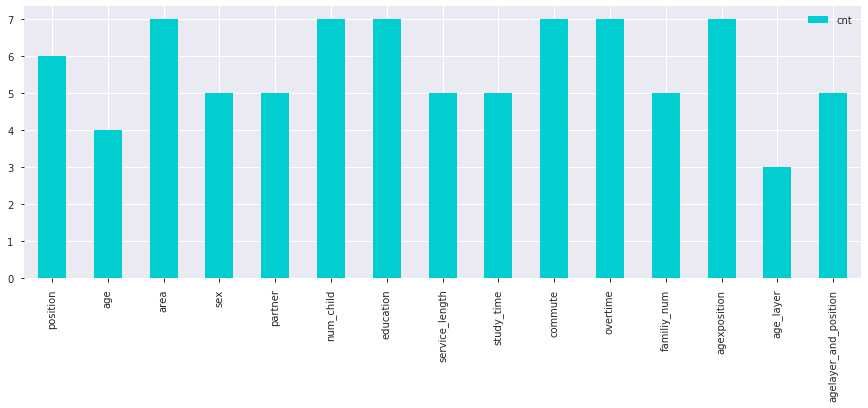

In [82]:
cols = X.columns.tolist()
 
# positive_cnt = int(df['salary'].sum())

feature_importance_models = [
    ensemble.AdaBoostRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
    tree.DecisionTreeRegressor(),
    xgb.XGBRegressor(),
    lgb.LGBMRegressor()
]
 
scoring = ['rsme']
df_rfe_cols_cnt = pd.DataFrame(columns=['cnt'], index=cols)
df_rfe_cols_cnt['cnt'] = 0
 
for i, model in tqdm(enumerate(feature_importance_models), total=len(feature_importance_models)):
    
    rfe = feature_selection.RFECV(model, step=2)
    rfe.fit(X, y)
#     print(rfe.get_support())
    rfe_cols = X[cols].columns.values[rfe.get_support()]
    df_rfe_cols_cnt.loc[rfe_cols, 'cnt'] += 1
    
df_rfe_cols_cnt.plot(kind='bar', color=base_color, figsize=(15, 5))
plt.show()

In [10]:
x_cols = df_rfe_cols_cnt[df_rfe_cols_cnt['cnt'] < 4].index
X=X.drop(x_cols,axis=1)
test=test.drop(x_cols,axis=1)
train_X, valid_X,train_y, valid_y = train_test_split(X,y,test_size=0.2,random_state=43)

## XGBoost+optuna

In [87]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import optuna
from sklearn.metrics import r2_score

class RidgeCV():
    model_cls = Ridge

    def __init__(self, n_trials=100):
        self.n_trials = n_trials

    def fit(self, X, y):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)
        elif isinstance(X, pd.DataFrame):
            X = X.reset_index(drop=True)
            y = y.reset_index(drop=True)

        self.X = X
        self.y = y

#         study = optuna.create_study(direction='maximize')
        study = optuna.create_study(direction='minimize')
        study.optimize(self, n_trials=self.n_trials)
        self.best_trial = study.best_trial

        print()
        print("Best score:", round(self.best_trial.value, 2))
        print("Best params:", self.best_trial.params)
        print()

        self.best_model = self.model_cls(**self.best_trial.params)
        self.best_model.fit(self.X, self.y)

    def predict(self, X):
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X.values.reshape(1, -1))
        elif isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        return self.best_model.predict(X)

    def score(self, X, y):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)

        return self.best_model.score(X, y)

    def kfold_cv(self, model, splits=5):
        scores = []

        kf = KFold(n_splits=splits, shuffle=True)
        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]
            model.fit(X_train, y_train)
            scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp(y_test)))

        score = np.array(scores).mean()
        return score

In [95]:


import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
def fair(preds,dtrain):
    x=pred-dtrain.get_labels()
    c=1
    den=abs(x)+c
    grad=c*x/den
    hess=c*c/den**2
    return grad,hess

class XGBRegressorCV(RidgeCV):
    model_cls = xgb.XGBRegressor

    def __call__(self, trial):
        booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
        alpha = trial.suggest_loguniform('alpha', 1e-8, 1.0)

        max_depth = trial.suggest_int('max_depth', 1, 20)
        eta = trial.suggest_loguniform('eta', 1e-8, 1.0)
        gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        grow_policy = trial.suggest_categorical(
            'grow_policy', ['depthwise', 'lossguide'])

        if booster == 'gbtree':
            model = self.model_cls(silent=1, booster=booster,
                                   alpha=alpha, max_depth=max_depth, eta=eta,
                                   gamma=gamma, grow_policy=grow_policy,obj=fair)
        elif booster == 'dart':
            sample_type = trial.suggest_categorical('sample_type',
                                                    ['uniform', 'weighted'])
            normalize_type = trial.suggest_categorical('normalize_type',
                                                       ['tree', 'forest'])
            rate_drop = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
            skip_drop = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
            model = self.model_cls(silent=1, booster=booster,
                                   alpha=alpha, max_depth=max_depth, eta=eta,
                                   gamma=gamma, grow_policy=grow_policy,
                                   sample_type=sample_type,
                                   normalize_type=normalize_type,
                                   rate_drop=rate_drop, skip_drop=skip_drop,obj=fair)

        score = self.kfold_cv(model)
        return score

xgbr = XGBRegressorCV(n_trials=100)
xgbr.fit(X, y)

# pred_y=xgbr.predict(valid_X)
# score=mean_absolute_error(np.exp(valid_y),np.exp(xgbr.predict(valid_X)))
# print(f'MAE:{score:4f}')
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# kf = KFold(n_splits=3, shuffle=True, random_state=0)
# model = XGBRegressorCV(n_trials=10)
# scores = []


# for train_index, test_index in kf.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     model.fit(X_train, y_train)
#     scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
# print(scores)
# print(np.array(scores).mean())
#MAE:22.821581(drop)dummy
#MAE:22.753628(nodrop)dummy

[I 2019-12-14 08:35:01,320] Finished trial#0 resulted in value: 23.42550554467494. Current best value is 23.42550554467494 with parameters: {'booster': 'gbtree', 'alpha': 0.00039015894223598687, 'max_depth': 17, 'eta': 2.642625033095959e-05, 'gamma': 4.703783105821707e-08, 'grow_policy': 'depthwise'}.
[I 2019-12-14 08:35:51,709] Finished trial#1 resulted in value: 22.83640580773193. Current best value is 22.83640580773193 with parameters: {'booster': 'dart', 'alpha': 5.771144707649304e-06, 'max_depth': 17, 'eta': 4.443651356754542e-08, 'gamma': 0.0037766688883270312, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0008849101653068881, 'skip_drop': 0.02582931643198075}.
[I 2019-12-14 08:36:01,055] Finished trial#2 resulted in value: 22.494880355832002. Current best value is 22.494880355832002 with parameters: {'booster': 'gbtree', 'alpha': 0.0003745930982209492, 'max_depth': 10, 'eta': 0.00030875961226197926, 'gamma': 2.6080628299130206e-0

KeyboardInterrupt: 

# LightGBM+optuna

In [96]:
# coding:utf-8
import lightgbm as lgb
# from sklearn.metrics import log_loss
def min_max_normalization(x):
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / ( x_max - x_min)
    return x_norm
def min_max_renormalization(x1,x2):
    x_min = x2.min()
    x_max = x2.max()
#     x_norm = (x2 - x_min) / ( x_max - x_min)
    x=x1*  ( x_max - x_min)+x_min
    return x

import lightgbm as lgb
# from sklearn.metrics import log_loss
cat_list = ['area', 'sex', 'partner','education']
class LGBRegressorCV(RidgeCV):
    model_cls = lgb.LGBMRegressor
    def __call__(self, trial):
        params = {
#             'eval_metric':'mae',
#             'booster':trial.suggest_categorical('booster',['gbtree','gblinear']),
#             'loss_function': 'fair',
#             'iterations' : trial.suggest_int('iterations', 50, 400),                      
            'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf' , 0, 300),  
#             'depth':16,
            'regression_l1':'mean_absolute_error',
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
#             'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
#             'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
#             'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
#             'od_wait' :trial.suggest_int('od_wait', 10, 50),
            'metric': 'binary_logloss',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score

model=LGBRegressorCV(n_trials=1000)

# kf = KFold(n_splits=3, shuffle=True, random_state=0)
# model = XGBRegressorCV(n_trials=20)
model.fit(X,y)
# scores = []


# for train_index, test_index in kf.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     model.fit(X_train, y_train)
#     scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
# print(scores)
# print(np.array(scores).mean())
# checktesty=valid_y.sort_values()
# checktestX=valid_X.ix[list(checktesty.index)]
# checktesty=checktesty.reset_index(drop=True)#これと

# checkpred=pd.DataFrame(model.predict(checktestX))#これ
# check=pd.concat([checktesty,checkpred], axis=1)
# check.columns=["actual","predict"]
# check.plot(alpha=0.5)
#MAE:23.144563 (nodrop)dummy
#MAE:23.742147(drop)dummy
#MAE:23.902507nodummy
# {'min_data_in_leaf': 0, 'learning_rate': 0.07131890785023809, 'lambda_l1': 0.008778053223443966, 'lambda_l2': 0.0027277990779868114, 'num_leaves': 132, 'feature_fraction': 0.9229335416500064, 'bagging_fraction': 0.7089417478461842, 'bagging_freq': 2, 'min_child_samples': 43}
# {'min_data_in_leaf': 5, 'learning_rate': 0.07638638625945278, 'lambda_l1': 2.1020653691858665e-07, 'lambda_l2': 0.010561897128809217, 'num_leaves': 161, 'feature_fraction': 0.9892805155059393, 'bagging_fraction': 0.9415631406590197, 'bagging_freq': 6, 'min_child_samples': 31}
model_cls = lgb.LGBMRegressor()

[I 2019-12-14 09:00:14,424] Finished trial#0 resulted in value: 23.98895525860568. Current best value is 23.98895525860568 with parameters: {'min_data_in_leaf': 226, 'learning_rate': 0.16480051466545598, 'lambda_l1': 0.006683542206007123, 'lambda_l2': 5.918114815347754e-08, 'num_leaves': 159, 'feature_fraction': 0.5609747007220792, 'bagging_fraction': 0.9762928236415476, 'bagging_freq': 6, 'min_child_samples': 25}.
[I 2019-12-14 09:00:16,035] Finished trial#1 resulted in value: 26.192679097010426. Current best value is 23.98895525860568 with parameters: {'min_data_in_leaf': 226, 'learning_rate': 0.16480051466545598, 'lambda_l1': 0.006683542206007123, 'lambda_l2': 5.918114815347754e-08, 'num_leaves': 159, 'feature_fraction': 0.5609747007220792, 'bagging_fraction': 0.9762928236415476, 'bagging_freq': 6, 'min_child_samples': 25}.
[I 2019-12-14 09:00:17,745] Finished trial#2 resulted in value: 26.4188358341999. Current best value is 23.98895525860568 with parameters: {'min_data_in_leaf': 2

KeyboardInterrupt: 

In [9]:
    
class LGBRegressor1CV(RidgeCV):
    model_cls = lgb.LGBMRegressor
    def __call__(self, trial):
        params = {
            'loss_function': 'xentropy loss',
            'iterations' : trial.suggest_int('iterations', 50, 300),                      
            'depth' : trial.suggest_int('depth', 8, 20), 
#             'depth':16,
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
            'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score

model=LGBRegressor1CV(n_trials=20)
ylgm=min_max_normalization(y)
# model.fit(X,ylgm)



# pred_y=min_max_renormalization(model.predict(valid_X),train_y)
# score=mean_absolute_error(np.exp(valid_y),np.exp(pred_y))
# print(f'MAE:{score:4f}')
# pred=model.predict(test)


## CatBoost+optuna(non recomended)

In [ ]:
from catboost import CatBoost
# from sklearn.metrics import log_loss

class CatRegressorCV(RidgeCV):
    model_cls = CatBoost
    def __call__(self, trial):
        params = {
            'loss_function': 'MAE',
#             'iterations' : trial.suggest_int('iterations', 50, 300),                      
            'depth' : trial.suggest_int('depth', 6, 10),                                      
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
            'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }
        model=self.model_cls(params)
        score = self.kfold_cv(model)
        return score
model=CatRegressorCV(n_trials=50)
model.fit(X,y)
# model=CatBoost({"depth":9})
# model=CatBoost({'depth':16,'learning_rate': 0.05235680460545009, 'random_strength': 68, 'bagging_temperature': 0.5832808626920046, 'od_type': 'IncToDec', 'od_wait': 10, })
# model.fit(train_X,train_y)

# pred_y=model.predict(valid_X)
# score=mean_absolute_error(np.exp(valid_y),np.exp(model.predict(valid_X)))
# print(f'MAE:{score:4f}')
# pred=model.predict(test)
# 9 MAE:22.430658

0:	learn: 5.2814289	total: 82.6ms	remaining: 1m 22s
1:	learn: 4.8195368	total: 93ms	remaining: 46.4s
2:	learn: 4.3965478	total: 98.6ms	remaining: 32.8s
3:	learn: 4.0134310	total: 105ms	remaining: 26.3s
4:	learn: 3.6639156	total: 112ms	remaining: 22.2s
5:	learn: 3.3446177	total: 117ms	remaining: 19.4s
6:	learn: 3.0534733	total: 123ms	remaining: 17.5s
7:	learn: 2.7877830	total: 129ms	remaining: 16.1s
8:	learn: 2.5412866	total: 135ms	remaining: 14.9s
9:	learn: 2.3209095	total: 140ms	remaining: 13.9s
10:	learn: 2.1207746	total: 144ms	remaining: 12.9s
11:	learn: 1.9363820	total: 149ms	remaining: 12.3s
12:	learn: 1.7695522	total: 155ms	remaining: 11.8s
13:	learn: 1.6185547	total: 161ms	remaining: 11.3s
14:	learn: 1.4791169	total: 165ms	remaining: 10.9s
15:	learn: 1.3517477	total: 171ms	remaining: 10.5s
16:	learn: 1.2345539	total: 176ms	remaining: 10.2s
17:	learn: 1.1261068	total: 180ms	remaining: 9.79s
18:	learn: 1.0300654	total: 185ms	remaining: 9.53s
19:	learn: 0.9429000	total: 188ms	remai

[I 2019-12-14 10:14:13,052] Finished trial#0 resulted in value: 24.281695004320955. Current best value is 24.281695004320955 with parameters: {'depth': 8, 'learning_rate': 0.08818720497892826, 'random_strength': 76, 'bagging_temperature': 1.6400777671861633, 'od_type': 'Iter', 'od_wait': 11}.


0:	learn: 5.6369568	total: 11ms	remaining: 10.9s
1:	learn: 5.4877847	total: 18.3ms	remaining: 9.12s
2:	learn: 5.3422844	total: 24.5ms	remaining: 8.15s
3:	learn: 5.2010499	total: 29.5ms	remaining: 7.35s
4:	learn: 5.0640781	total: 34.6ms	remaining: 6.88s
5:	learn: 4.9308965	total: 39.2ms	remaining: 6.5s
6:	learn: 4.8007673	total: 43.4ms	remaining: 6.16s
7:	learn: 4.6742964	total: 47.4ms	remaining: 5.88s
8:	learn: 4.5509420	total: 51.8ms	remaining: 5.7s
9:	learn: 4.4302057	total: 55.9ms	remaining: 5.53s
10:	learn: 4.3132808	total: 60.1ms	remaining: 5.4s
11:	learn: 4.2004393	total: 64.2ms	remaining: 5.29s
12:	learn: 4.0900100	total: 68.3ms	remaining: 5.19s
13:	learn: 3.9824910	total: 72.4ms	remaining: 5.1s
14:	learn: 3.8779118	total: 76.4ms	remaining: 5.01s
15:	learn: 3.7759288	total: 80.6ms	remaining: 4.96s
16:	learn: 3.6764301	total: 84.7ms	remaining: 4.9s
17:	learn: 3.5791814	total: 89ms	remaining: 4.86s
18:	learn: 3.4849845	total: 93.2ms	remaining: 4.81s
19:	learn: 3.3935654	total: 97.

[I 2019-12-14 10:14:35,750] Finished trial#1 resulted in value: 24.40750170402503. Current best value is 24.281695004320955 with parameters: {'depth': 8, 'learning_rate': 0.08818720497892826, 'random_strength': 76, 'bagging_temperature': 1.6400777671861633, 'od_type': 'Iter', 'od_wait': 11}.


0:	learn: 3.0186710	total: 10.1ms	remaining: 10s
1:	learn: 1.5680363	total: 18.3ms	remaining: 9.13s
2:	learn: 0.8119155	total: 23.9ms	remaining: 7.93s
3:	learn: 0.4302633	total: 29.3ms	remaining: 7.31s
4:	learn: 0.2442416	total: 34ms	remaining: 6.76s
5:	learn: 0.1739221	total: 38.8ms	remaining: 6.42s
6:	learn: 0.1468189	total: 42.8ms	remaining: 6.07s
7:	learn: 0.1382670	total: 46.8ms	remaining: 5.8s
8:	learn: 0.1286242	total: 51.1ms	remaining: 5.62s
9:	learn: 0.1263076	total: 55.1ms	remaining: 5.46s
10:	learn: 0.1247653	total: 59.2ms	remaining: 5.32s
11:	learn: 0.1229354	total: 63.3ms	remaining: 5.21s
12:	learn: 0.1213016	total: 67.5ms	remaining: 5.12s
13:	learn: 0.1191383	total: 71.6ms	remaining: 5.04s
14:	learn: 0.1185887	total: 75.5ms	remaining: 4.96s
15:	learn: 0.1177978	total: 79.7ms	remaining: 4.9s
16:	learn: 0.1161397	total: 84ms	remaining: 4.86s
17:	learn: 0.1132117	total: 88.3ms	remaining: 4.82s
18:	learn: 0.1084149	total: 92.5ms	remaining: 4.77s
19:	learn: 0.1074951	total: 96

[I 2019-12-14 10:14:58,522] Finished trial#2 resulted in value: 26.796918066860137. Current best value is 24.281695004320955 with parameters: {'depth': 8, 'learning_rate': 0.08818720497892826, 'random_strength': 76, 'bagging_temperature': 1.6400777671861633, 'od_type': 'Iter', 'od_wait': 11}.


0:	learn: 5.6129059	total: 11.9ms	remaining: 11.9s
1:	learn: 5.4438761	total: 20.5ms	remaining: 10.2s
2:	learn: 5.2792390	total: 24.8ms	remaining: 8.24s
3:	learn: 5.1206538	total: 30.8ms	remaining: 7.67s
4:	learn: 4.9666725	total: 35.8ms	remaining: 7.13s
5:	learn: 4.8172495	total: 40.3ms	remaining: 6.67s
6:	learn: 4.6723674	total: 45ms	remaining: 6.39s
7:	learn: 4.5315891	total: 49.7ms	remaining: 6.17s
8:	learn: 4.3938826	total: 54.4ms	remaining: 5.99s
9:	learn: 4.2618029	total: 58.2ms	remaining: 5.76s
10:	learn: 4.1338599	total: 61.6ms	remaining: 5.54s
11:	learn: 4.0092255	total: 66.2ms	remaining: 5.45s
12:	learn: 3.8887366	total: 71.1ms	remaining: 5.4s
13:	learn: 3.7726013	total: 75.7ms	remaining: 5.33s
14:	learn: 3.6591169	total: 80.1ms	remaining: 5.26s
15:	learn: 3.5491932	total: 84.7ms	remaining: 5.21s
16:	learn: 3.4421258	total: 89.5ms	remaining: 5.17s
17:	learn: 3.3381939	total: 93ms	remaining: 5.07s
18:	learn: 3.2382044	total: 97.8ms	remaining: 5.05s
19:	learn: 3.1414365	total:

# Randomforest +optuna

In [11]:
class RFRegressorCV(RidgeCV):
    model_cls =  RFR
    def __call__(self, trial):
        params = {
            'n_estimators'      : trial.suggest_int('n_estimators', 10, 200),
            'max_features'      : trial.suggest_int('max_features', 1,self.X.shape[1]),
            'random_state'      : 123,
            'n_jobs'            : 1,
            'min_samples_split' :trial.suggest_int('min_samples_split', 3, 100) ,
            'max_depth'         : trial.suggest_int('max_depth' , 3, 100)
        }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score
model=RFRegressorCV(n_trials=20)
# model.fit(X,y)

# pred_y=model.predict(valid_X)
# score=mean_absolute_error(np.exp(valid_y),np.exp(model.predict(valid_X)))
# print(f'MAE:{score:4f}')
# pred=model.predict(test)

# DecitionTree

In [98]:
from sklearn import tree
class DecisionRegressorCV(RidgeCV):
    model_cls =  tree.DecisionTreeRegressor
    def __call__(self, trial):
        params = {
#             'n_estimators'      : trial.suggest_int('n_estimators', 10, 200),
            'max_features'      : trial.suggest_int('max_features', 1,self.X.shape[1]),
            'random_state'      : 123,
#             'n_jobs'            : 1,
            'min_samples_split' :trial.suggest_int('min_samples_split', 3, 100) ,
            'max_depth'         : trial.suggest_int('max_depth' , 3, 100)
        }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score
model=DecisionRegressorCV(n_trials=100)
#{'depth': 7, 'learning_rate': 0.074638569770399, 'random_strength': 59, 'bagging_temperature': 0.011038111194790014, 'od_type': 'IncToDec', 'od_wait': 12})
# model=CatBoost({'depth':16,'learning_rate': 0.05235680460545009, 'random_strength': 68, 'bagging_temperature': 0.5832808626920046, 'od_type': 'IncToDec', 'od_wait': 10, })
model.fit(X,y)


[I 2019-12-14 09:22:27,572] Finished trial#0 resulted in value: 27.652788241459007. Current best value is 27.652788241459007 with parameters: {'max_features': 5, 'min_samples_split': 27, 'max_depth': 25}.
[I 2019-12-14 09:22:27,962] Finished trial#1 resulted in value: 26.237459613085598. Current best value is 26.237459613085598 with parameters: {'max_features': 9, 'min_samples_split': 56, 'max_depth': 11}.
[I 2019-12-14 09:22:28,305] Finished trial#2 resulted in value: 36.80030346134813. Current best value is 26.237459613085598 with parameters: {'max_features': 9, 'min_samples_split': 56, 'max_depth': 11}.
[I 2019-12-14 09:22:28,629] Finished trial#3 resulted in value: 35.26420594736679. Current best value is 26.237459613085598 with parameters: {'max_features': 9, 'min_samples_split': 56, 'max_depth': 11}.
[I 2019-12-14 09:22:29,049] Finished trial#4 resulted in value: 25.526986953274665. Current best value is 25.526986953274665 with parameters: {'max_features': 10, 'min_samples_split'


Best score: 25.09
Best params: {'max_features': 12, 'min_samples_split': 39, 'max_depth': 28}



# Extra tree(tree)

In [109]:
class ExtraTreeRegressorCV(RidgeCV):
    model_cls = tree.ExtraTreeRegressor
    def __call__(self, trial):
        params = {
            'criterion':'mae',
#             'n_estimators'      : trial.suggest_int('n_estimators', 10, 200),
            'max_features'      : trial.suggest_int('max_features', 1,self.X.shape[1]),
            'random_state'      : 123,
#             'n_jobs'            : 1,
            'min_samples_split' :trial.suggest_int('min_samples_split', 3, 100) ,
            'max_depth'         : trial.suggest_int('max_depth' , 3, 100)
        }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score
model=ExtraTreeRegressorCV(n_trials=200)
#{'depth': 7, 'learning_rate': 0.074638569770399, 'random_strength': 59, 'bagging_temperature': 0.011038111194790014, 'od_type': 'IncToDec', 'od_wait': 12})
# model=CatBoost({'depth':16,'learning_rate': 0.05235680460545009, 'random_strength': 68, 'bagging_temperature': 0.5832808626920046, 'od_type': 'IncToDec', 'od_wait': 10, })
model.fit(X,y)


[I 2019-12-14 09:33:49,702] Finished trial#0 resulted in value: 35.950026699777176. Current best value is 35.950026699777176 with parameters: {'max_features': 6, 'min_samples_split': 37, 'max_depth': 14}.
[I 2019-12-14 09:34:10,325] Finished trial#1 resulted in value: 28.02521036591873. Current best value is 28.02521036591873 with parameters: {'max_features': 14, 'min_samples_split': 15, 'max_depth': 43}.
[I 2019-12-14 09:34:20,546] Finished trial#2 resulted in value: 34.26161957770249. Current best value is 28.02521036591873 with parameters: {'max_features': 14, 'min_samples_split': 15, 'max_depth': 43}.
[I 2019-12-14 09:34:37,648] Finished trial#3 resulted in value: 30.238711322728612. Current best value is 28.02521036591873 with parameters: {'max_features': 14, 'min_samples_split': 15, 'max_depth': 43}.
[I 2019-12-14 09:34:43,282] Finished trial#4 resulted in value: 50.75107442822746. Current best value is 28.02521036591873 with parameters: {'max_features': 14, 'min_samples_split': 

KeyboardInterrupt: 

# GradientBoost

In [110]:
from sklearn import ensemble

class GBRegressorCV(RidgeCV):
    model_cls =  ensemble.GradientBoostingRegressor
    def __call__(self, trial):
        params = {
#             'n_estimators'      : trial.suggest_int('n_estimators', 10, 200),
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
            'max_features'      : trial.suggest_int('max_features', 1,self.X.shape[1]),
            'random_state'      : 123,
            'min_samples_split' :trial.suggest_int('min_samples_split', 3, 100) ,
            'max_depth'         : trial.suggest_int('max_depth' , 3, 20)
        }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score
model=GBRegressorCV(n_trials=100)
model.fit(X,y)

[I 2019-12-14 09:47:19,140] Finished trial#0 resulted in value: 29.600289168905192. Current best value is 29.600289168905192 with parameters: {'learning_rate': 0.34573002335630626, 'max_features': 1, 'min_samples_split': 6, 'max_depth': 8}.
[I 2019-12-14 09:47:20,225] Finished trial#1 resulted in value: 29.90900076844715. Current best value is 29.600289168905192 with parameters: {'learning_rate': 0.34573002335630626, 'max_features': 1, 'min_samples_split': 6, 'max_depth': 8}.
[I 2019-12-14 09:47:30,266] Finished trial#2 resulted in value: 23.42345038027361. Current best value is 23.42345038027361 with parameters: {'learning_rate': 0.12179973722543411, 'max_features': 3, 'min_samples_split': 72, 'max_depth': 19}.
[I 2019-12-14 09:48:06,199] Finished trial#3 resulted in value: 24.431370575228907. Current best value is 23.42345038027361 with parameters: {'learning_rate': 0.12179973722543411, 'max_features': 3, 'min_samples_split': 72, 'max_depth': 19}.
[I 2019-12-14 09:48:23,783] Finished

KeyboardInterrupt: 

# BaggingRegressor

In [108]:


class BaggingRegressorCV(RidgeCV):
    model_cls =  ensemble.BaggingRegressor
    def __call__(self, trial):
        params = {
            'base_estimator':tree.DecisionTreeRegressor(**{'max_features': 12, 'min_samples_split': 39, 'max_depth': 28}),
            'n_estimators'      : trial.suggest_int('n_estimators', 10, 200),              
#             'max_features'      : trial.suggest_int('max_features', 1,self.X.shape[1]),
            'random_state'      : 123,
        }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score
model=BaggingRegressorCV(n_trials=20)
model.fit(X,y)

[I 2019-12-14 09:31:34,087] Finished trial#0 resulted in value: 22.62137126887828. Current best value is 22.62137126887828 with parameters: {'n_estimators': 48}.
[I 2019-12-14 09:31:50,382] Finished trial#1 resulted in value: 22.641182996722563. Current best value is 22.62137126887828 with parameters: {'n_estimators': 48}.
[I 2019-12-14 09:31:57,066] Finished trial#2 resulted in value: 22.709397733575123. Current best value is 22.62137126887828 with parameters: {'n_estimators': 48}.
[I 2019-12-14 09:32:19,666] Finished trial#3 resulted in value: 22.613544223336937. Current best value is 22.613544223336937 with parameters: {'n_estimators': 174}.
[I 2019-12-14 09:32:40,968] Finished trial#4 resulted in value: 22.60703860248061. Current best value is 22.60703860248061 with parameters: {'n_estimators': 164}.


KeyboardInterrupt: 

# Adaboost1

In [100]:
class AdaboostRegressorCV(RidgeCV):
    model_cls =  ensemble.AdaBoostRegressor
    def __call__(self, trial):
        params = {
            'base_estimator':tree.DecisionTreeRegressor(**{'max_features': 12, 'min_samples_split': 39, 'max_depth': 28}),
            'n_estimators'      : trial.suggest_int('n_estimators', 10, 200),
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
#             'max_features'      : trial.suggest_int('max_features', 1,self.X.shape[1]),
            'random_state'      : 123,
            'loss':'linear',
        }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score
model=AdaboostRegressorCV(n_trials=100)
model.fit(X,y)

[I 2019-12-14 09:23:57,059] Finished trial#0 resulted in value: 21.92890572483092. Current best value is 21.92890572483092 with parameters: {'n_estimators': 65, 'learning_rate': 0.02114817966488267}.
[I 2019-12-14 09:24:27,495] Finished trial#1 resulted in value: 21.744616518249238. Current best value is 21.744616518249238 with parameters: {'n_estimators': 146, 'learning_rate': 0.16958029819927525}.
[I 2019-12-14 09:25:08,236] Finished trial#2 resulted in value: 21.745159601205696. Current best value is 21.744616518249238 with parameters: {'n_estimators': 146, 'learning_rate': 0.16958029819927525}.
[I 2019-12-14 09:25:44,983] Finished trial#3 resulted in value: 21.670247747423804. Current best value is 21.670247747423804 with parameters: {'n_estimators': 172, 'learning_rate': 0.07114576882858845}.
[I 2019-12-14 09:25:58,031] Finished trial#4 resulted in value: 21.98500424322244. Current best value is 21.670247747423804 with parameters: {'n_estimators': 172, 'learning_rate': 0.071145768

KeyboardInterrupt: 

In [17]:
class AdaboostRegressorCV(RidgeCV):
    model_cls =  ensemble.AdaBoostRegressor
    def __call__(self, trial):
        params = {
            'base_estimator':tree.DecisionTreeRegressor(**{'max_features': 12, 'min_samples_split': 40, 'max_depth': 72}),
            'n_estimators'      : trial.suggest_int('n_estimators', 10, 200),
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
#             'max_features'      : trial.suggest_int('max_features', 1,self.X.shape[1]),
            'random_state'      : 123,
            'loss':'linear',
        }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score
model=AdaboostRegressorCV(n_trials=20)
# model.fit(X,y)

# HistGradientBoostingRegressor

In [112]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
class HGBRegressorCV(RidgeCV):
    model_cls =  HistGradientBoostingRegressor
    def __call__(self, trial):
        params = {
#             'max_iter ': trial.suggest_int('max_iter ', 10, 200),
            'max_leaf_nodes':trial.suggest_int('max_leaf_nodes ', 31,1023),
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
#             'max_features'      : trial.suggest_int('max_features', 1,self.X.shape[1]),
            'random_state'      : 123,
            'min_samples_leaf' :trial.suggest_int('min_samples_split', 3, 100) ,
            'max_depth'         : trial.suggest_int('max_depth' , 3, 20)
        }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score
model=HGBRegressorCV(n_trials=100)
model.fit(X,y)

[I 2019-12-14 10:08:35,003] Finished trial#0 resulted in value: 26.060365347507393. Current best value is 26.060365347507393 with parameters: {'max_leaf_nodes ': 489, 'learning_rate': 0.46968176079935176, 'min_samples_split': 19, 'max_depth': 13}.
[I 2019-12-14 10:08:36,531] Finished trial#1 resulted in value: 24.152653214884175. Current best value is 24.152653214884175 with parameters: {'max_leaf_nodes ': 858, 'learning_rate': 0.08502682136389463, 'min_samples_split': 24, 'max_depth': 5}.
[I 2019-12-14 10:08:45,096] Finished trial#2 resulted in value: 23.578896192533954. Current best value is 23.578896192533954 with parameters: {'max_leaf_nodes ': 942, 'learning_rate': 0.03561607391448941, 'min_samples_split': 74, 'max_depth': 20}.
[I 2019-12-14 10:08:47,682] Finished trial#3 resulted in value: 22.844300255663814. Current best value is 22.844300255663814 with parameters: {'max_leaf_nodes ': 70, 'learning_rate': 0.22070605649938957, 'min_samples_split': 63, 'max_depth': 8}.
[I 2019-12-

KeyboardInterrupt: 

# FastRGFRegressor

In [19]:
from rgf.sklearn import FastRGFRegressor 
class FastRGFRegressorCV(RidgeCV):
    model_cls =  FastRGFRegressor
    def __call__(self, trial):
        params = {
#             'max_iter ': trial.suggest_int('max_iter ', 10, 200),
            'max_leaf':trial.suggest_int('max_leaf', 31,1023),
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
#             'max_features'      : trial.suggest_int('max_features', 1,self.X.shape[1]),
#             'random_state'      : 123,
            'min_samples_leaf' :trial.suggest_int('min_samples_split', 3, 100) ,
            'max_depth'         : trial.suggest_int('max_depth' , 3, 20)
        }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score
model=FastRGFRegressorCV(n_trials=20)
# model.fit(X,y)

/Users/ogatatakuya/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

/Users/ogatatakuya/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



# ERT(ensemble)

In [97]:
class ERTRegressorCV(RidgeCV):
    model_cls =  ensemble.ExtraTreesRegressor
    def __call__(self, trial):
        params = {
            'n_estimators'      : trial.suggest_int('n_estimators', 10, 200),
            'max_features'      : trial.suggest_int('max_features', 1,self.X.shape[1]),
            'random_state'      : 123,
            'n_jobs'            : 1,
            'min_samples_split' :trial.suggest_int('min_samples_split', 3, 100) ,
            'max_depth'         : trial.suggest_int('max_depth' , 3, 100)
        }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score
model=ERTRegressorCV(n_trials=300)
model.fit(X,y)


[I 2019-12-14 09:13:50,969] Finished trial#0 resulted in value: 28.225581177780178. Current best value is 28.225581177780178 with parameters: {'n_estimators': 17, 'max_features': 9, 'min_samples_split': 95, 'max_depth': 92}.
[I 2019-12-14 09:13:54,732] Finished trial#1 resulted in value: 31.65532544117063. Current best value is 28.225581177780178 with parameters: {'n_estimators': 17, 'max_features': 9, 'min_samples_split': 95, 'max_depth': 92}.
[I 2019-12-14 09:14:00,681] Finished trial#2 resulted in value: 26.464976565816777. Current best value is 26.464976565816777 with parameters: {'n_estimators': 129, 'max_features': 9, 'min_samples_split': 40, 'max_depth': 12}.
[I 2019-12-14 09:14:02,846] Finished trial#3 resulted in value: 49.82462111951748. Current best value is 26.464976565816777 with parameters: {'n_estimators': 129, 'max_features': 9, 'min_samples_split': 40, 'max_depth': 12}.
[I 2019-12-14 09:14:08,322] Finished trial#4 resulted in value: 35.644523566125315. Current best val

KeyboardInterrupt: 

## Data engeneering for NN

In [21]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
categorical_variable_names = ["position","sex","education"]
# カテゴリ変数に一括変換
# x_dummy = pd.get_dummies(df[categorical_variable_names], drop_first=True,columns=categorical_variable_names)
# X_nn=df.drop(categorical_variable_names, axis=1)
X_nn=df
sscaler =StandardScaler()
sscaler.fit(X_nn)  

x_datas_std =sscaler.transform(X_nn)
x_datas_std = pd.DataFrame(x_datas_std, columns=X_nn.columns)
X_nn= pd.concat([x_datas_std,], axis=1)


train_X_nn=X_nn.drop("id",axis=1)
test_nn=X_nn[X_nn.salary.isnull()].drop("id",axis=1)
test_nn= test_nn.drop(["salary",],axis=1)
train_X_nn= train_X_nn.dropna().drop(["salary"],axis=1)

In [22]:
# #ニューラルネットワークモデルの生成
# from keras.models import Sequential
# from keras.layers import Dense

# model = Sequential()
# model.add(Dense(1000, activation = 'relu'))
# model.add(Dense(800, activation = 'relu'))
# model.add(Dense(100, activation =  'relu'))
# model.add(Dense(1))
# # モデルをコンパイル 
# from keras.optimizers import Adam
# # ylgm=min_max_normalization(y)
train_X_nn, valid_X_nn,train_y_nn, valid_y_nn = train_test_split(train_X_nn,y,test_size=0.2,random_state=43)

# model.compile(Adam(lr=1e-3), loss="mean_squared_error")
# #トレーニングデータで学習し，テストデータで評価（平均2乗誤差を用いる）
# history = model.fit(np.array(train_X_nn), np.array(train_y_nn), batch_size=128, epochs=100, verbose=1, 
#           validation_data=(np.array(valid_X_nn), np.array(valid_y_nn)))

NameError: name 'train_test_split' is not defined

In [23]:
# #結果の表示
# import matplotlib.pyplot as plt #プロット用のライブラリを利用

# print(model.evaluate(valid_X_nn, valid_y_nn))

# train_acc = history.history['loss']
# test_acc = history.history['val_loss']
# x = np.arange(len(train_acc))
# plt.plot(x, train_acc, label = 'train mse')
# plt.plot(x, test_acc, label = 'test mse')
# plt.legend() #グラフの線の説明を表示

In [24]:
# pred_y=model.predict(valid_X_nn)
# score=mean_absolute_error(np.exp(valid_y_nn),np.exp(pred_y))
# print(f'MAE:{score:4f}')
# pred=model.predict(test_nn)


# Stacking

In [25]:
from sklearn.ensemble import RandomForestRegressor as RFR
def cross_val(model,X,y):
    scores = []
    kf = KFold(n_splits=3, shuffle=True, random_state=0)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
#     print(scores)
    return np.array(scores).mean()

models_dic = {
    'random forest': RFRegressorCV(n_trials=10),
    'lightgbm':LGBRegressorCV(n_trials=10),
    'XGBoost': XGBRegressorCV(n_trials=5),
    'catboost':CatBoost({'learning_rate': 0.17321274085322982, 'random_strength': 94, 'bagging_temperature': 0.2804904005490844, 'od_type': 'IncToDec', 'od_wait': 50})
}

for name, model in models_dic.items():
    cv_results=cross_val(model,X,y)
    print(f'{name} : {-np.mean(cv_results):.2f}')

KeyboardInterrupt: 

In [29]:
!pip list

Package                Version  
---------------------- ---------
absl-py                0.8.1    
aioredis               1.3.0    
alembic                1.3.0    
aniso8601              8.0.0    
appnope                0.1.0    
asgiref                3.2.3    
asn1crypto             1.2.0    
astor                  0.8.0    
astroid                2.3.3    
astropy                3.2.3    
async-timeout          3.0.1    
atomicwrites           1.3.0    
attrs                  19.3.0   
autobahn               19.11.1  
Automat                0.8.0    
backcall               0.1.0    
bayesian-optimization  1.0.1    
beautifulsoup4         4.8.1    
bhtsne                 0.1.9    
bleach                 3.1.0    
blis                   0.4.1    
bokeh                  1.4.0    
Boruta                 0.3      
boto                   2.49.0   
boto3                  1.10.14  
botocore               1.13.14  
cachetools             3.1.1    
catboost               0.18.1   
certifi   

In [30]:
# datasetを準備
seed=0
from heamy.dataset import Dataset
from heamy.estimator import Regressor
from heamy.pipeline import ModelsPipeline
import catboost

dataset = Dataset(X, y, test) # X_testは今回使わないが入れないとエラーになる

# アンサンブルに使うモデルを定義
models = [
    Regressor(dataset=dataset, estimator=RFR, parameters={'n_estimators': 130, 'max_features': 10, 'min_samples_split': 9, 'max_depth': 76},name="REF"),
    Regressor(dataset=dataset, estimator= lgb.LGBMRegressor,parameters={'booster': 'gbtree', 'iterations': 325, 'learning_rate': 0.12390268669497792, 'random_strength': 99, 'bagging_temperature': 0.15768364625112835, 'od_type': 'Iter', 'od_wait': 11, 'lambda_l1': 1.9836559852087728e-08, 'lambda_l2': 0.00010343157903947435, 'num_leaves': 189, 'feature_fraction': 0.6834534921425951, 'bagging_fraction': 0.9933185372338379, 'bagging_freq': 5, 'min_child_samples': 77},name="LGB"),
    Regressor(dataset=dataset, estimator=xgb.XGBRegressor,parameters={'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06},name="xgbr"),
    Regressor(dataset=dataset, estimator=catboost.CatBoostRegressor,parameters={'learning_rate': 0.17321274085322982, 'random_strength': 94, 'bagging_temperature': 0.2804904005490844, 'od_type': 'IncToDec', 'od_wait': 50}, name='cr'),
    Regressor(dataset=dataset, estimator=tree.DecisionTreeRegressor,name="Decision",parameters={'max_features': 12, 'min_samples_split': 40, 'max_depth': 72})
]

# pipelineを定義、2nd levelデータセットの作成
pipeline = ModelsPipeline(*models)
stack_ds = pipeline.stack(k=10, seed=seed)

# modelを作ってvalidation
stacker = Regressor(dataset=stack_ds, estimator=linear_model.Ridge)
y_trues, y_preds = stacker.validate(k=10)

# 精度出力
cv_results = []
for y_true, y_pred in zip(y_trues, y_preds):
    cv_result = mean_absolute_error(np.exp(y_true),np.exp(y_pred))
    cv_results.append(cv_result)
print(f'stacking: {np.mean(cv_results):.2f}')

# X_testを使ってpredict
y_pred = stacker.predict()

KeyboardInterrupt: 

In [ ]:
# datasetを準備　スタッキング
seed=0
from heamy.dataset import Dataset
from heamy.estimator import Regressor
from heamy.pipeline import ModelsPipeline
from sklearn import metrics,  feature_selection, ensemble, gaussian_process, linear_model, naive_bayes, neighbors, svm, tree, discriminant_analysis, model_selection,cross_decomposition
# from imblearn import under_sampling, over_sampling
from sklearn.metrics import make_scorer,mean_absolute_error
import lightgbm as lgb
import xgboost as xgb
import catboost 
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.svm as SVM
categorical_variable_names = ["position","sex","education"]
# カテゴリ変数に一括変換
# x_dummy = pd.get_dummies(df[categorical_variable_names], drop_first=True,columns=categorical_variable_names)
# X_nn=df.drop(categorical_variable_names, axis=1)
X_nn=df
sscaler =StandardScaler()
sscaler.fit(X_nn)  

x_datas_std =sscaler.transform(X_nn)
x_datas_std = pd.DataFrame(x_datas_std, columns=X_nn.columns)
X_nn= pd.concat([x_datas_std,], axis=1)


train_X_nn=X_nn.drop("id",axis=1)
test_nn=X_nn[X_nn.salary.isnull()].drop("id",axis=1)
test_nn= test_nn.drop(["salary",],axis=1)
train_X_nn= train_X_nn.dropna().drop(["salary"],axis=1)
dataset_nn =Dataset( train_X_nn,y,test_nn)
dataset = Dataset(X, y, test) # X_testは今回使わないが入れないとエラーになる

def xgb_first(X_train, y_train, X_test, y_test=None):
    model=XGBRegressorCV(n_trials=50)
    model.fit(pd.DataFrame(X_train), pd.Series(y_train))
    return model.predict(X_test)

def lgb_first(X_train, y_train, X_test, y_test=None):
    model=LGBRegressorCV(n_trials=100)
    model.fit(pd.DataFrame(X_train), pd.Series(y_train))
    return model.predict(X_test)
# def FRGFR(X_train, y_train, X_test, y_test=None):
#     parameters={'n_estimators': 113, 'max_features': 11, 'min_samples_split': 8, 'max_depth': 52}
#     model=FastRGFRegressor(**parameters)
# #     model=FastRGFRegressor()
#     model.fit(pd.DataFrame(X_train), pd.Series(y_train))
#     return model.predict(pd.DataFrame(X_test))
# アンサンブルに使うモデルを定義
models = [
#     {'booster': 'dart', 'alpha': 8.1194481080174e-08, 'max_depth': 12, 'eta': 2.5713027232528782e-05, 'gamma': 0.02400165668149876, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.3142247988071326e-07, 'skip_drop': 0.08221914377357924}
    Regressor(dataset=dataset, estimator= lgb.LGBMRegressor,parameters={'min_data_in_leaf': 2, 'learning_rate': 0.0623697284562841, 'lambda_l1': 3.7842152029119874e-07, 'lambda_l2': 0.013806415765349557, 'num_leaves': 174, 'feature_fraction': 0.9283089162269392, 'bagging_fraction': 0.9208156139910044, 'bagging_freq': 1, 'min_child_samples': 80},name="LGB3"),
    Regressor(dataset=dataset, estimator=ensemble.ExtraTreesRegressor,parameters={'n_estimators': 195, 'max_features': 14, 'min_samples_split': 10, 'max_depth': 34},name="ETR"), 

    Regressor(dataset=dataset_nn, estimator=linear_model.ElasticNet,name="ElasticNet"), 
    Regressor(dataset=dataset_nn, estimator=cross_decomposition.PLSRegression,name="PLSR"),  
#     Regressor(dataset=dataset_nn, estimator=SVM.SVR,name="SVR"),  
    Regressor(dataset=dataset_nn, estimator=neighbors.KNeighborsRegressor,name="KNR"),   
#     Regressor(dataset=dataset_nn, estimator=SVM.LinearSVR,name="linearSVR"),    
    Regressor(dataset=dataset_nn, estimator=SVM.NuSVR,name="NuSVR"),    
    Regressor(dataset=dataset_nn, estimator=gaussian_process.GaussianProcessRegressor,name="GPR"),
#     Regressor(dataset=dataset, estimator=xgb_first,name="xgb_first"),
    Regressor(dataset=dataset, estimator=lgb_first,name="lgb_first"),
#     Regressor(dataset=dataset_nn, estimator=linear_model.Ridge,name="Ridge"),

#     Regressor(dataset=dataset, estimator= lgb.LGBMRegressor,name="LGB"),
    Regressor(dataset=dataset, estimator=xgb.XGBRegressor,name="xgbr"),
    Regressor(dataset=dataset, estimator=catboost.CatBoostRegressor, name='cr'),

#     Regressor(dataset=dataset, estimator= lgb.LGBMRegressor,parameters={'min_data_in_leaf': 5, 'learning_rate': 0.06494539810752878, 'lambda_l1': 1.024409417996912e-05, 'lambda_l2': 0.02887121230310398, 'num_leaves': 132, 'feature_fraction': 0.9989421253414971, 'bagging_fraction': 0.8950993800668274, 'bagging_freq': 1, 'min_child_samples': 6},name="LGB1"),
    Regressor(dataset=dataset, estimator=xgb.XGBRegressor,parameters={'booster': 'gbtree', 'alpha': 1.141674060800846e-05, 'max_depth': 12, 'eta': 0.12295502409538879, 'gamma': 0.02217019580560904, 'grow_policy': 'lossguide'},name="xgbr1"),
    Regressor(dataset=dataset, estimator=catboost.CatBoostRegressor,parameters={'learning_rate': 0.17321274085322982, 'random_strength': 94, 'bagging_temperature': 0.2804904005490844, 'od_type': 'IncToDec', 'od_wait': 50}, name='cr1'),

    Regressor(dataset=dataset, estimator=ensemble.GradientBoostingRegressor,name="GBR",parameters={'learning_rate': 0.049596460111132126, 'max_features': 10, 'min_samples_split': 54, 'max_depth': 10}),

    Regressor(dataset=dataset, estimator=ensemble.AdaBoostRegressor,parameters={'n_estimators': 172, 'learning_rate': 0.07114576882858845,'base_estimator':tree.DecisionTreeRegressor(**{'max_features': 12, 'min_samples_split': 39, 'max_depth': 28})},name="AB1"),

    Regressor(dataset=dataset, estimator=ensemble.AdaBoostRegressor,parameters={'n_estimators': 172, 'learning_rate': 0.07114576882858845,'base_estimator':tree.ExtraTreeRegressor(**{'max_features': 14, 'min_samples_split': 36, 'max_depth': 46})},name="AB2"),
    Regressor(dataset=dataset, estimator=ensemble.BaggingRegressor,parameters={'n_estimators': 79,'base_estimator':tree.DecisionTreeRegressor(**{'max_features': 12, 'min_samples_split': 39, 'max_depth': 28})},name="BR1"),
#     Regressor(dataset=dataset, estimator=ensemble.BaggingRegressor,parameters={'n_estimators': 79, 'max_features': 13,'base_estimator':tree.ExtraTreeRegressor(**{'max_features': 13, 'min_samples_split': 35, 'max_depth': 86})},name="BR2"),
    Regressor(dataset=dataset, estimator=ensemble.AdaBoostRegressor,parameters={'n_estimators': 138, 'learning_rate': 0.01352845512490716,'base_estimator':tree.ExtraTreeRegressor()},name="AB3"),
    Regressor(dataset=dataset, estimator=ensemble.BaggingRegressor,parameters={'n_estimators': 79, 'max_features': 13,'base_estimator':tree.ExtraTreeRegressor()},name="BR3"),
    Regressor(dataset=dataset_nn, estimator=MLPRegressor,parameters={"hidden_layer_sizes":(100,100,100,100),"random_state":42},name="MLPR"),
#     Regressor(dataset=dataset, estimator=HistGradientBoostingRegressor,parameters={'max_leaf_nodes': 197, 'learning_rate': 0.11247427508088689, 'max_depth': 12},name="HGBR1"),

    Regressor(dataset=dataset_nn, estimator=MLPRegressor,parameters={"hidden_layer_sizes":(100,100,100,100,100),"random_state":42},name="MLPR1"),

#     Regressor(dataset=dataset, estimator=catboost.CatBoostRegressor,parameters={'depth':9,'learning_rate': 0.17321274085322982, 'random_strength': 94, 'bagging_temperature': 0.2804904005490844, 'od_type': 'IncToDec', 'od_wait': 50}, name='cr2'),
    Regressor(dataset=dataset, estimator=catboost.CatBoostRegressor,parameters={'depth': 6, 'learning_rate': 0.08836825370956872, 'random_strength': 0, 'bagging_temperature': 0.07070770882170724, 'od_type': 'Iter', 'od_wait': 19}, name='cr3'),
#     Regressor(dataset=dataset_nn, estimator=linear_model.PassiveAggressiveRegressor,name="PAR"),
#     Regressor(dataset=dataset, estimator= lgb.LGBMRegressor,parameters={'learning_rate': 0.09392346343123249, 'lambda_l1': 6.4482395958889154e-06, 'lambda_l2': 0.1612049736816089, 'num_leaves': 92, 'feature_fraction': 0.8891712345135501, 'bagging_fraction': 0.9991968565440735, 'bagging_freq': 2, 'min_child_samples': 7},name="LGB2"),
#     Regressor(dataset=dataset, estimator=xgb.XGBRegressor,parameters={'booster': 'gbtree', 'alpha': 3.248112697400248e-06, 'max_depth': 13, 'eta': 2.6042223396416813e-08, 'gamma': 0.03878371160795443, 'grow_policy': 'lossguide'},name="xgbr2"),
    # {'booster': 'gbtree', 'alpha': 3.248112697400248e-06, 'max_depth': 13, 'eta': 2.6042223396416813e-08, 'gamma': 0.03878371160795443, 'grow_policy': 'lossguide'}  
#    Regressor(dataset=dataset, estimator=catboost.CatBoostRegressor,parameters={'depth': 9, 'learning_rate': 0.05394102013496231, 'random_strength': 0, 'bagging_temperature': 36.50726339742334, 'od_type': 'Iter', 'od_wait': 31}, name='cr2'),
]

# pipelineを定義、2nd levelデータセットの作成
pipeline = ModelsPipeline(*models)
stack_ds = pipeline.stack(k=10, seed=seed)

# modelを作ってvalidation
stacker = Regressor(dataset=stack_ds, estimator=linear_model.Ridge)
# stacker = Regressor(dataset=stack_ds, estimator=lgb_first)
y_trues, y_preds = stacker.validate(k=10)

# 精度出力
cv_results = []
for y_true, y_pred in zip(y_trues, y_preds):
    cv_result = mean_absolute_error(np.exp(y_true),np.exp(y_pred))
    cv_results.append(cv_result)
print(f'stacking: {np.mean(cv_results):.5f}')
# X_testを使ってpredict
y_pred = stacker.predict()
#21.04642よりも小さいと嬉しい。


# blending

In [119]:
# datasetを準備　ブレンディング
seed=0
from heamy.dataset import Dataset
from heamy.estimator import Regressor
from heamy.pipeline import ModelsPipeline
import catboost
import sklearn.svm as SVM

dataset = Dataset(X, y, test) # X_testは今回使わないが入れないとエラーになる

# アンサンブルに使うモデルを定義
models = [
#   linear_model.ARDRegression ElasticNet Lasso FastRGFRegressor {'learning_rate': 0.017373741462374484, 'min_samples_split': 8, 'max_depth': 7}
#     Regressor(dataset=dataset, estimator=ensemble.ExtraTreesRegressor,parameters={'n_estimators': 113, 'max_features': 11, 'min_samples_split': 8, 'max_depth': 52},name="ETR"), 
    Regressor(dataset=dataset, estimator=FRGFR,name="FRGF"), 
    Regressor(dataset=dataset_nn, estimator=linear_model.ElasticNet,name="ElasticNet"), 
    Regressor(dataset=dataset_nn, estimator=cross_decomposition.PLSRegression,name="PLSR"),  
    Regressor(dataset=dataset_nn, estimator=SVM.SVR,name="SVR"),  
    Regressor(dataset=dataset_nn, estimator=neighbors.KNeighborsRegressor,name="KNR"),   
    Regressor(dataset=dataset_nn, estimator=SVM.LinearSVR,name="linearSVR"),    
    Regressor(dataset=dataset_nn, estimator=SVM.NuSVR,name="NuSVR"),    
    Regressor(dataset=dataset_nn, estimator=gaussian_process.GaussianProcessRegressor,name="GPR"),
    Regressor(dataset=dataset, estimator=xgb_first,name="xgb_first"),
    Regressor(dataset=dataset, estimator=lgb_first,name="lgb_first"),
    Regressor(dataset=dataset_nn, estimator=linear_model.Ridge,name="Ridge"),
#     Regressor(dataset=dataset, estimator=RFR,name="RFR"),
    Regressor(dataset=dataset, estimator= lgb.LGBMRegressor,name="LGB"),
    Regressor(dataset=dataset, estimator=xgb.XGBRegressor,name="xgbr"),
    Regressor(dataset=dataset, estimator=catboost.CatBoostRegressor, name='cr'),
#     Regressor(dataset=dataset, estimator=RFR, parameters={'n_estimators': 130, 'max_features': 10, 'min_samples_split': 9, 'max_depth': 76},name="REF1"),
    Regressor(dataset=dataset, estimator= lgb.LGBMRegressor,parameters={'booster': 'gbtree', 'iterations': 325, 'learning_rate': 0.12390268669497792, 'random_strength': 99, 'bagging_temperature': 0.15768364625112835, 'od_type': 'Iter', 'od_wait': 11, 'lambda_l1': 1.9836559852087728e-08, 'lambda_l2': 0.00010343157903947435, 'num_leaves': 189, 'feature_fraction': 0.6834534921425951, 'bagging_fraction': 0.9933185372338379, 'bagging_freq': 5, 'min_child_samples': 77},name="LGB1"),
    Regressor(dataset=dataset, estimator=xgb.XGBRegressor,parameters={'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06},name="xgbr1"),
    Regressor(dataset=dataset, estimator=catboost.CatBoostRegressor,parameters={'learning_rate': 0.17321274085322982, 'random_strength': 94, 'bagging_temperature': 0.2804904005490844, 'od_type': 'IncToDec', 'od_wait': 50}, name='cr1'),
#     Regressor(dataset=dataset, estimator=tree.DecisionTreeRegressor,name="Decision",parameters={'max_features': 12, 'min_samples_split': 40, 'max_depth': 72}),
    Regressor(dataset=dataset, estimator=ensemble.GradientBoostingRegressor,name="GBR",parameters={'learning_rate': 0.05132811273357581, 'max_features': 11, 'min_samples_split': 13, 'max_depth': 12}),
#     Regressor(dataset=dataset, estimator=ensemble.BaggingRegressor,parameters={'n_estimators': 79, 'max_features': 13},name="BR"),
    Regressor(dataset=dataset, estimator=ensemble.AdaBoostRegressor,parameters={'n_estimators': 138, 'learning_rate': 0.03375962775310903,'base_estimator':tree.DecisionTreeRegressor(**{'max_features': 12, 'min_samples_split': 40, 'max_depth': 72})},name="AB1"),
#     Regressor(dataset=dataset, estimator=tree.ExtraTreeRegressor,parameters={'max_features': 13, 'min_samples_split': 35, 'max_depth': 86},name="EX"),
    Regressor(dataset=dataset, estimator=ensemble.AdaBoostRegressor,parameters={'n_estimators': 138, 'learning_rate': 0.01352845512490716,'base_estimator':tree.ExtraTreeRegressor(**{'max_features': 13, 'min_samples_split': 35, 'max_depth': 86})},name="AB2"),
    Regressor(dataset=dataset, estimator=ensemble.BaggingRegressor,parameters={'n_estimators': 79, 'max_features': 13,'base_estimator':tree.DecisionTreeRegressor(**{'max_features': 12, 'min_samples_split': 40, 'max_depth': 72})},name="BR1"),
    Regressor(dataset=dataset, estimator=ensemble.BaggingRegressor,parameters={'n_estimators': 79, 'max_features': 13,'base_estimator':tree.ExtraTreeRegressor(**{'max_features': 13, 'min_samples_split': 35, 'max_depth': 86})},name="BR2"),
    Regressor(dataset=dataset, estimator=ensemble.AdaBoostRegressor,parameters={'n_estimators': 138, 'learning_rate': 0.01352845512490716,'base_estimator':tree.ExtraTreeRegressor()},name="AB3"),
    Regressor(dataset=dataset, estimator=ensemble.BaggingRegressor,parameters={'n_estimators': 79, 'max_features': 13,'base_estimator':tree.ExtraTreeRegressor()},name="BR3"),
#     Regressor(dataset=dataset_nn, estimator=MLPRegressor,parameters={"hidden_layer_sizes":(100,100,100,100),"random_state":42},name="MLPR"),
    Regressor(dataset=dataset, estimator=HistGradientBoostingRegressor,parameters={'max_leaf_nodes': 197, 'learning_rate': 0.11247427508088689, 'max_depth': 12},name="HGBR1"),
#     Regressor(dataset=dataset, estimator=HistGradientBoostingRegressor,name="HGBR2"),
 
]
# pipelineを定義、2nd levelデータセットの作成
pipeline = ModelsPipeline(*models)
stack_ds = pipeline.blend(proportion=0.2, seed=seed)

# modelを作ってvalidation
stacker = Regressor(dataset=stack_ds, estimator=linear_model.Ridge)
y_trues, y_preds = stacker.validate(k=10)

# 精度出力
cv_results = []
for y_true, y_pred in zip(y_trues, y_preds):
    cv_result = mean_absolute_error(np.exp(y_true),np.exp(y_pred))
    cv_results.append(cv_result)
print(f'blending: {np.mean(cv_results):.2f}')

# X_testを使ってpredict
y_pred = stacker.predict()

TypeError: __init__() got an unexpected keyword argument 'max_features'

In [9]:
pred=np.exp(xgbr.predict(test))


In [10]:

sub = pd.DataFrame(pd.read_csv("test_data.csv")['id'])
sub["y"] = list(pred)
sub.to_csv("submission.csv", index = False)

In [149]:
pred=np.exp(y_pred)
sub = pd.DataFrame(pd.read_csv("test_data.csv")['id'])
sub["y"] = list(pred)
sub.to_csv("submission.csv", index = False)